In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset

sys.path.insert(0, '../Utils')

import models
from train import *
from metrics import *  
from data_downloaders import *

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


In [2]:
n_epochs = 2000
batch_size = 128
lr = 0.0001

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


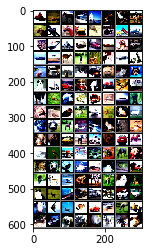

In [3]:
# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = 10

# load training set 
trainset = torchvision.datasets.CIFAR10('../Datasets/', train=True, transform=transform, download=True)

total_size = len(trainset)
split = total_size // 2
indices = list(range(total_size))

train_idx = indices[:split]
out_idx = indices[split:]


train_sampler = SubsetRandomSampler(train_idx)
out_sampler = SubsetRandomSampler(out_idx)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
outloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=out_sampler, num_workers=2)


# load test set 
testset = torchvision.datasets.CIFAR10('../../Datasets/', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs))


In [4]:
def label_to_onehot(labels, num_classes=10): 
    one_hot = torch.eye(num_classes)
    return one_hot[labels]


class inference_attack(nn.Module): 
    def __init__(self, n_classes): 
        super(inference_attack, self).__init__()
        
        self.n_classes = n_classes
        
        self.prediction_vector_block = nn.Sequential(
            nn.Linear(n_classes, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Linear(512, 64), 
            nn.ReLU()
        )
        
        self.label_block = nn.Sequential(
            nn.Linear(n_classes, 512), 
            nn.ReLU(), 
            nn.Linear(512, 64), 
            nn.ReLU()
        )
        
        self.common_block = nn.Sequential(
            nn.Linear(128, 256), 
            nn.ReLU(), 
            nn.Linear(256, 64), 
            nn.ReLU(), 
            nn.Linear(64, 1)
            
        )
        
    def forward(self, prediction_vector, one_hot_label): 
        prediction_block_out = self.prediction_vector_block(prediction_vector)
        label_block_out = self.label_block(one_hot_label)
        #print(prediction_block_out)
        #print(label_block_out)

        
        out = F.sigmoid(self.common_block(torch.cat((prediction_block_out, label_block_out), dim=1)))
        return out
    

    

In [5]:
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg16 = torchvision.models.vgg16(num_classes=10)
# vgg16 fix for cifar10 image size 
vgg16.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, 10),
        )


#net = resnet18.to(device)
net = vgg16.to(device)




net.apply(models.weights_init)

class_loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
class_optim = optim.Adam(net.parameters(), lr=lr)


infer_net = inference_attack(num_classes).to(device)

infer_loss = nn.BCELoss()
infer_optim = optim.Adam(infer_net.parameters(), lr=lr)

/usr/local/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
def adversarial_train(inference_net, classification_net, train_set, out_set, test_set, 
                      infer_optim, infer_loss, class_optim, class_loss, n_epochs, k, privacy_theta):
    losses = []

    inference_net.train()
    classification_net.train()
    
    
    
    for epoch in range(n_epochs):




        train_top = np.array([])
        out_top = np.array([])
        
        total_inference = 0
        total_correct_inference = 0
        
        inference_losses = np.array([])
        classification_losses = np.array([])
        
        for k_count in range(k): 
            # train inference network 
            train_imgs, train_lbls = iter(train_set).next()
            train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)
            out_imgs, out_lbls = iter(out_set).next()
            out_imgs, out_lbls = out_imgs.to(device), out_lbls.to(device)
            
            mini_batch_size = train_imgs.shape[0]
            
            train_lbl = torch.ones(mini_batch_size).to(device)
            out_lbl = torch.zeros(mini_batch_size).to(device)
            
            train_posteriors = F.softmax(classification_net(train_imgs), dim=1)
            out_posteriors = F.softmax(classification_net(out_imgs), dim=1)
            
            train_sort, _ = torch.sort(train_posteriors, descending=True)
            out_sort, _ = torch.sort(out_posteriors, descending=True)

            
            train_top = np.concatenate((train_top, train_sort[:,0].cpu().detach().numpy()))
            out_top = np.concatenate((out_top, out_sort[:,0].cpu().detach().numpy()))
            
            infer_optim.zero_grad()

            train_inference = torch.squeeze(inference_net(train_posteriors, label_to_onehot(train_lbls).to(device)))
            out_inference = torch.squeeze(inference_net(out_posteriors, label_to_onehot(out_lbls).to(device)))
            
            total_inference += 2*mini_batch_size
            total_correct_inference += torch.sum(train_inference > 0.5).item() + torch.sum(out_inference < 0.5).item()
            
            
            loss_train = infer_loss(train_inference, train_lbl)
            loss_out = infer_loss(out_inference, out_lbl)
            
            loss = privacy_theta * (loss_train + loss_out) / 2 
            loss.backward()
            
            infer_optim.step()
            
        
            

            
        
        
        # train classifiction network 
        train_imgs, train_lbls = iter(train_set).next()
        train_imgs, train_lbls = train_imgs.to(device), train_lbls.to(device)
        
        class_optim.zero_grad()

        outputs = classification_net(train_imgs)
        train_posteriors = F.softmax(outputs, dim=1)


        loss_classification = class_loss(outputs, train_lbls)
        train_lbl = torch.ones(mini_batch_size).to(device)
        
        train_inference = torch.squeeze(inference_net(train_posteriors, label_to_onehot(train_lbls).to(device)))
        loss_infer = infer_loss(train_inference, train_lbl)
        loss = loss_classification + privacy_theta * loss_infer
        
        loss.backward()
        class_optim.step()
        
        '''
        correct += (train_predictions>=0.5).sum().item()
        correct += (out_predictions<0.5).sum().item()
        total += train_predictions.size(0) + out_predictions.size(0)
        print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train), loss.item(), 100 * correct / total))
        '''        
        
        if epoch % 20 == 0 and epoch != 0: 
            plt.figure()
            sns.distplot(train_top,label='maximum train posterior')
            sns.distplot(out_top,label='maximum out posterior')
            plt.legend()
            plt.show()

            inference_accuracy = 100 * (total_correct_inference / total_inference)
            classification_accuracy = eval_target_net(classification_net, test_set, classes=classes)
            print("[%d/%d] Inference accuracy = %.2f%%, Classification accuracy = %.2f%%" % (epoch, n_epochs, inference_accuracy, classification_accuracy))
                  
        
                  

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


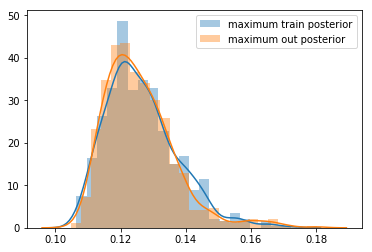

Accuracy of airplane : 97.80 %
Accuracy of automobile : 0.00 %
Accuracy of bird : 0.00 %
Accuracy of cat : 0.00 %
Accuracy of deer : 0.00 %
Accuracy of dog : 0.00 %
Accuracy of frog : 0.00 %
Accuracy of horse : 0.00 %
Accuracy of ship : 0.00 %
Accuracy of truck : 12.50 %

Total accuracy = 11.03 %


[20/2000] Inference accuracy = 48.05%, Classification accuracy = 11.03%


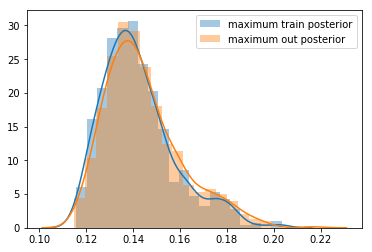

Accuracy of airplane : 75.80 %
Accuracy of automobile : 66.60 %
Accuracy of bird : 0.00 %
Accuracy of cat : 0.00 %
Accuracy of deer : 0.00 %
Accuracy of dog : 0.00 %
Accuracy of frog : 0.00 %
Accuracy of horse : 0.00 %
Accuracy of ship : 0.00 %
Accuracy of truck : 0.50 %

Total accuracy = 14.29 %


[40/2000] Inference accuracy = 49.22%, Classification accuracy = 14.29%


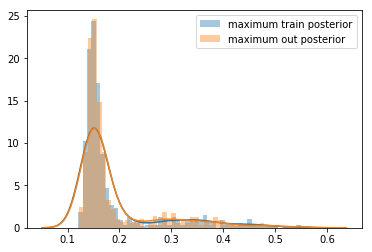

Accuracy of airplane : 82.00 %
Accuracy of automobile : 18.20 %
Accuracy of bird : 0.00 %
Accuracy of cat : 8.60 %
Accuracy of deer : 0.00 %
Accuracy of dog : 0.00 %
Accuracy of frog : 80.00 %
Accuracy of horse : 0.00 %
Accuracy of ship : 0.00 %
Accuracy of truck : 13.80 %

Total accuracy = 20.26 %


[60/2000] Inference accuracy = 50.39%, Classification accuracy = 20.26%


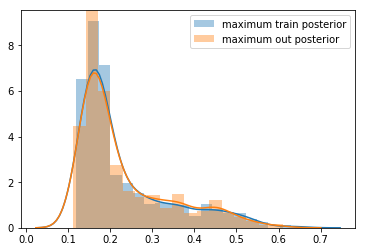

Accuracy of airplane : 67.20 %
Accuracy of automobile : 34.60 %
Accuracy of bird : 0.00 %
Accuracy of cat : 64.80 %
Accuracy of deer : 0.00 %
Accuracy of dog : 0.00 %
Accuracy of frog : 40.60 %
Accuracy of horse : 2.80 %
Accuracy of ship : 0.00 %
Accuracy of truck : 35.90 %

Total accuracy = 24.59 %


[80/2000] Inference accuracy = 50.86%, Classification accuracy = 24.59%


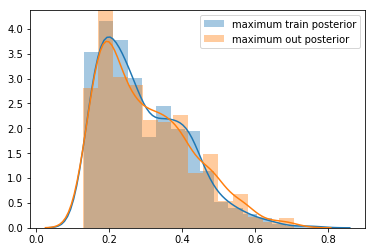

Accuracy of airplane : 43.90 %
Accuracy of automobile : 55.00 %
Accuracy of bird : 0.00 %
Accuracy of cat : 3.00 %
Accuracy of deer : 0.00 %
Accuracy of dog : 26.40 %
Accuracy of frog : 75.70 %
Accuracy of horse : 14.80 %
Accuracy of ship : 54.10 %
Accuracy of truck : 23.10 %

Total accuracy = 29.60 %


[100/2000] Inference accuracy = 52.19%, Classification accuracy = 29.60%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f94e02fed68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

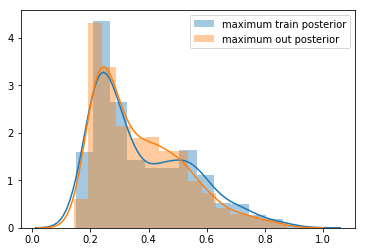

Accuracy of airplane : 60.80 %
Accuracy of automobile : 25.60 %
Accuracy of bird : 4.70 %
Accuracy of cat : 27.70 %
Accuracy of deer : 31.70 %
Accuracy of dog : 5.00 %
Accuracy of frog : 62.70 %
Accuracy of horse : 64.60 %
Accuracy of ship : 21.60 %
Accuracy of truck : 70.50 %

Total accuracy = 37.49 %


[180/2000] Inference accuracy = 51.88%, Classification accuracy = 37.49%


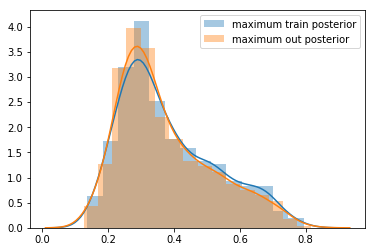

Accuracy of airplane : 48.80 %
Accuracy of automobile : 60.00 %
Accuracy of bird : 39.50 %
Accuracy of cat : 42.20 %
Accuracy of deer : 1.00 %
Accuracy of dog : 4.70 %
Accuracy of frog : 67.70 %
Accuracy of horse : 14.60 %
Accuracy of ship : 65.20 %
Accuracy of truck : 24.00 %

Total accuracy = 36.77 %


[200/2000] Inference accuracy = 48.12%, Classification accuracy = 36.77%


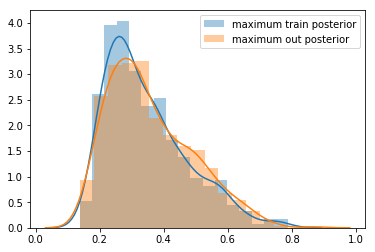

Accuracy of airplane : 39.30 %
Accuracy of automobile : 65.90 %
Accuracy of bird : 13.80 %
Accuracy of cat : 2.80 %
Accuracy of deer : 2.20 %
Accuracy of dog : 50.10 %
Accuracy of frog : 67.50 %
Accuracy of horse : 65.10 %
Accuracy of ship : 22.20 %
Accuracy of truck : 50.70 %

Total accuracy = 37.96 %


[220/2000] Inference accuracy = 48.12%, Classification accuracy = 37.96%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f94e0212080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

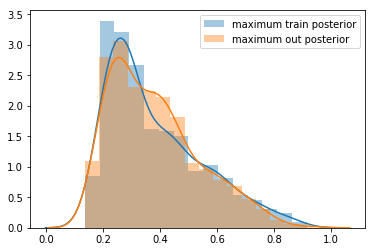

Accuracy of airplane : 53.60 %
Accuracy of automobile : 69.90 %
Accuracy of bird : 2.70 %
Accuracy of cat : 29.00 %
Accuracy of deer : 29.40 %
Accuracy of dog : 6.60 %
Accuracy of frog : 70.50 %
Accuracy of horse : 58.80 %
Accuracy of ship : 38.80 %
Accuracy of truck : 54.30 %

Total accuracy = 41.36 %


[240/2000] Inference accuracy = 50.47%, Classification accuracy = 41.36%


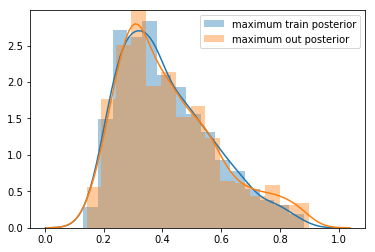

Accuracy of airplane : 53.10 %
Accuracy of automobile : 68.00 %
Accuracy of bird : 29.60 %
Accuracy of cat : 23.60 %
Accuracy of deer : 10.80 %
Accuracy of dog : 35.70 %
Accuracy of frog : 71.50 %
Accuracy of horse : 37.80 %
Accuracy of ship : 62.10 %
Accuracy of truck : 47.30 %

Total accuracy = 43.95 %


[260/2000] Inference accuracy = 49.92%, Classification accuracy = 43.95%


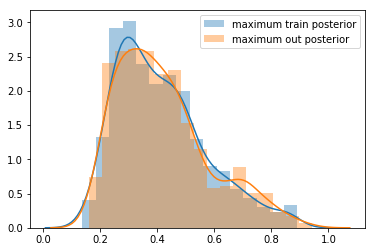

Accuracy of airplane : 40.50 %
Accuracy of automobile : 77.70 %
Accuracy of bird : 49.90 %
Accuracy of cat : 44.70 %
Accuracy of deer : 14.60 %
Accuracy of dog : 16.50 %
Accuracy of frog : 42.00 %
Accuracy of horse : 45.20 %
Accuracy of ship : 73.30 %
Accuracy of truck : 24.30 %

Total accuracy = 42.87 %


[280/2000] Inference accuracy = 52.42%, Classification accuracy = 42.87%


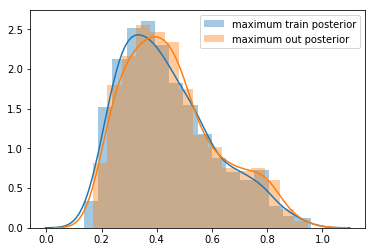

Accuracy of airplane : 58.50 %
Accuracy of automobile : 70.60 %
Accuracy of bird : 25.70 %
Accuracy of cat : 34.80 %
Accuracy of deer : 35.40 %
Accuracy of dog : 37.90 %
Accuracy of frog : 42.60 %
Accuracy of horse : 57.30 %
Accuracy of ship : 60.20 %
Accuracy of truck : 40.70 %

Total accuracy = 46.37 %


[300/2000] Inference accuracy = 47.11%, Classification accuracy = 46.37%


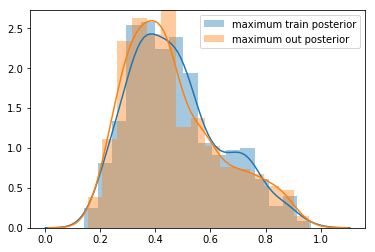

Accuracy of airplane : 45.40 %
Accuracy of automobile : 56.30 %
Accuracy of bird : 20.80 %
Accuracy of cat : 45.90 %
Accuracy of deer : 14.40 %
Accuracy of dog : 60.30 %
Accuracy of frog : 39.10 %
Accuracy of horse : 53.10 %
Accuracy of ship : 64.30 %
Accuracy of truck : 57.80 %

Total accuracy = 45.74 %


[320/2000] Inference accuracy = 51.02%, Classification accuracy = 45.74%


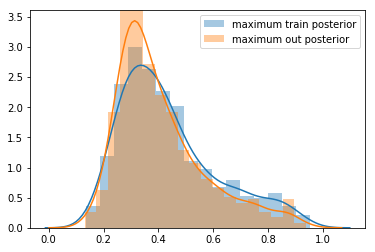

Accuracy of airplane : 33.30 %
Accuracy of automobile : 54.50 %
Accuracy of bird : 26.50 %
Accuracy of cat : 68.20 %
Accuracy of deer : 36.90 %
Accuracy of dog : 19.50 %
Accuracy of frog : 42.30 %
Accuracy of horse : 41.30 %
Accuracy of ship : 76.60 %
Accuracy of truck : 62.10 %

Total accuracy = 46.12 %


[340/2000] Inference accuracy = 48.52%, Classification accuracy = 46.12%


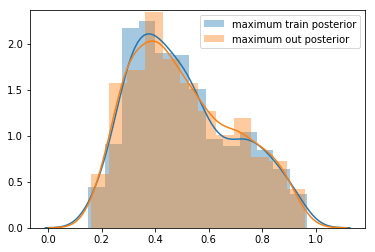

Accuracy of airplane : 45.70 %
Accuracy of automobile : 72.20 %
Accuracy of bird : 27.20 %
Accuracy of cat : 48.30 %
Accuracy of deer : 44.60 %
Accuracy of dog : 13.90 %
Accuracy of frog : 63.70 %
Accuracy of horse : 51.80 %
Accuracy of ship : 71.40 %
Accuracy of truck : 49.00 %

Total accuracy = 48.78 %


[360/2000] Inference accuracy = 51.17%, Classification accuracy = 48.78%


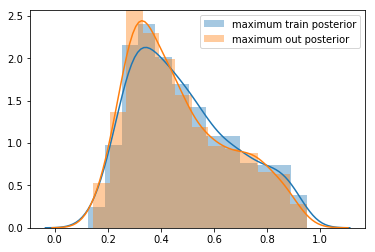

Accuracy of airplane : 52.70 %
Accuracy of automobile : 65.20 %
Accuracy of bird : 18.50 %
Accuracy of cat : 44.20 %
Accuracy of deer : 39.80 %
Accuracy of dog : 27.30 %
Accuracy of frog : 68.80 %
Accuracy of horse : 42.40 %
Accuracy of ship : 79.60 %
Accuracy of truck : 47.40 %

Total accuracy = 48.59 %


[380/2000] Inference accuracy = 52.03%, Classification accuracy = 48.59%


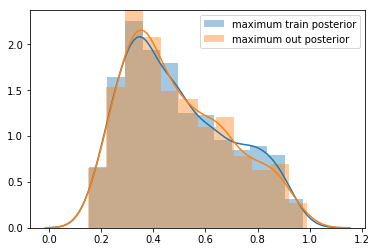

Accuracy of airplane : 60.70 %
Accuracy of automobile : 71.00 %
Accuracy of bird : 31.10 %
Accuracy of cat : 22.40 %
Accuracy of deer : 40.10 %
Accuracy of dog : 56.80 %
Accuracy of frog : 53.00 %
Accuracy of horse : 58.70 %
Accuracy of ship : 60.20 %
Accuracy of truck : 55.50 %

Total accuracy = 50.95 %


[400/2000] Inference accuracy = 50.94%, Classification accuracy = 50.95%


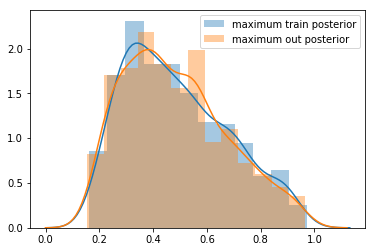

Accuracy of airplane : 54.40 %
Accuracy of automobile : 55.30 %
Accuracy of bird : 26.40 %
Accuracy of cat : 14.70 %
Accuracy of deer : 9.70 %
Accuracy of dog : 76.70 %
Accuracy of frog : 52.50 %
Accuracy of horse : 50.10 %
Accuracy of ship : 72.80 %
Accuracy of truck : 67.30 %

Total accuracy = 47.99 %


[420/2000] Inference accuracy = 50.39%, Classification accuracy = 47.99%


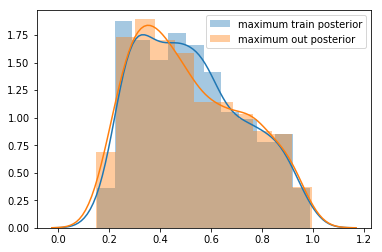

Accuracy of airplane : 46.70 %
Accuracy of automobile : 66.90 %
Accuracy of bird : 25.60 %
Accuracy of cat : 8.20 %
Accuracy of deer : 46.50 %
Accuracy of dog : 45.80 %
Accuracy of frog : 67.80 %
Accuracy of horse : 65.70 %
Accuracy of ship : 82.60 %
Accuracy of truck : 41.30 %

Total accuracy = 49.71 %


[440/2000] Inference accuracy = 51.17%, Classification accuracy = 49.71%


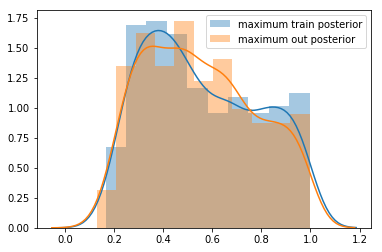

Accuracy of airplane : 53.80 %
Accuracy of automobile : 83.00 %
Accuracy of bird : 26.20 %
Accuracy of cat : 34.80 %
Accuracy of deer : 30.20 %
Accuracy of dog : 9.90 %
Accuracy of frog : 72.80 %
Accuracy of horse : 54.90 %
Accuracy of ship : 79.80 %
Accuracy of truck : 29.50 %

Total accuracy = 47.49 %


[460/2000] Inference accuracy = 51.02%, Classification accuracy = 47.49%


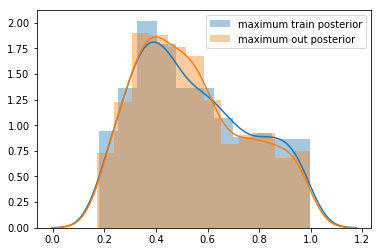

Accuracy of airplane : 60.60 %
Accuracy of automobile : 71.80 %
Accuracy of bird : 33.30 %
Accuracy of cat : 46.80 %
Accuracy of deer : 12.30 %
Accuracy of dog : 50.70 %
Accuracy of frog : 58.60 %
Accuracy of horse : 64.00 %
Accuracy of ship : 47.70 %
Accuracy of truck : 63.90 %

Total accuracy = 50.97 %


[480/2000] Inference accuracy = 53.12%, Classification accuracy = 50.97%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f94e02a3c50>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

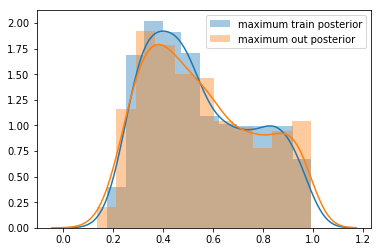

Accuracy of airplane : 58.20 %
Accuracy of automobile : 81.20 %
Accuracy of bird : 55.20 %
Accuracy of cat : 29.60 %
Accuracy of deer : 31.80 %
Accuracy of dog : 38.30 %
Accuracy of frog : 77.50 %
Accuracy of horse : 48.10 %
Accuracy of ship : 74.60 %
Accuracy of truck : 25.30 %

Total accuracy = 51.98 %


[500/2000] Inference accuracy = 50.78%, Classification accuracy = 51.98%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f94e067b710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

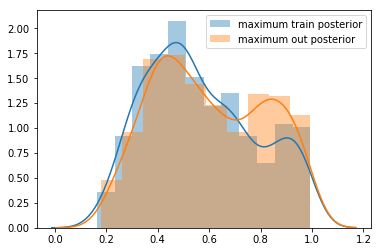

Accuracy of airplane : 61.10 %
Accuracy of automobile : 67.40 %
Accuracy of bird : 53.10 %
Accuracy of cat : 38.70 %
Accuracy of deer : 33.30 %
Accuracy of dog : 21.60 %
Accuracy of frog : 77.40 %
Accuracy of horse : 61.00 %
Accuracy of ship : 65.10 %
Accuracy of truck : 48.70 %

Total accuracy = 52.74 %


[520/2000] Inference accuracy = 49.14%, Classification accuracy = 52.74%


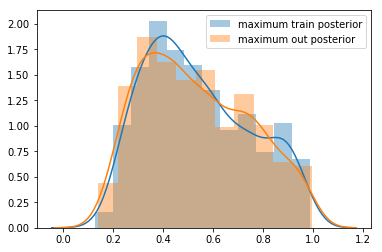

Accuracy of airplane : 44.40 %
Accuracy of automobile : 72.00 %
Accuracy of bird : 48.20 %
Accuracy of cat : 30.20 %
Accuracy of deer : 27.90 %
Accuracy of dog : 41.40 %
Accuracy of frog : 81.40 %
Accuracy of horse : 67.00 %
Accuracy of ship : 72.00 %
Accuracy of truck : 56.30 %

Total accuracy = 54.08 %


[540/2000] Inference accuracy = 48.28%, Classification accuracy = 54.08%


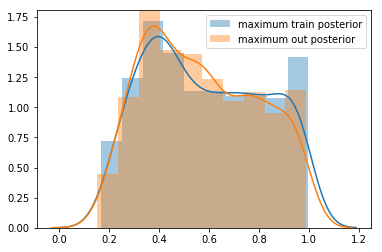

Accuracy of airplane : 51.40 %
Accuracy of automobile : 65.50 %
Accuracy of bird : 59.80 %
Accuracy of cat : 23.90 %
Accuracy of deer : 13.10 %
Accuracy of dog : 62.60 %
Accuracy of frog : 68.20 %
Accuracy of horse : 64.90 %
Accuracy of ship : 69.00 %
Accuracy of truck : 59.50 %

Total accuracy = 53.79 %


[560/2000] Inference accuracy = 48.52%, Classification accuracy = 53.79%


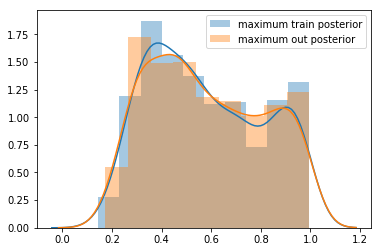

Accuracy of airplane : 43.50 %
Accuracy of automobile : 61.50 %
Accuracy of bird : 40.80 %
Accuracy of cat : 25.40 %
Accuracy of deer : 33.90 %
Accuracy of dog : 46.20 %
Accuracy of frog : 74.50 %
Accuracy of horse : 63.50 %
Accuracy of ship : 85.60 %
Accuracy of truck : 71.50 %

Total accuracy = 54.64 %


[580/2000] Inference accuracy = 50.39%, Classification accuracy = 54.64%


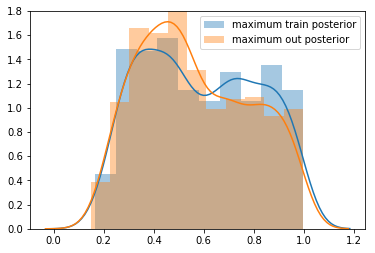

Accuracy of airplane : 54.20 %
Accuracy of automobile : 82.10 %
Accuracy of bird : 50.60 %
Accuracy of cat : 6.20 %
Accuracy of deer : 27.30 %
Accuracy of dog : 69.80 %
Accuracy of frog : 62.00 %
Accuracy of horse : 56.80 %
Accuracy of ship : 76.50 %
Accuracy of truck : 56.30 %

Total accuracy = 54.18 %


[600/2000] Inference accuracy = 49.92%, Classification accuracy = 54.18%


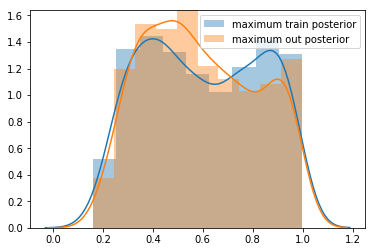

Accuracy of airplane : 58.00 %
Accuracy of automobile : 69.60 %
Accuracy of bird : 32.80 %
Accuracy of cat : 22.20 %
Accuracy of deer : 33.90 %
Accuracy of dog : 63.60 %
Accuracy of frog : 69.40 %
Accuracy of horse : 68.30 %
Accuracy of ship : 75.90 %
Accuracy of truck : 61.20 %

Total accuracy = 55.49 %


[620/2000] Inference accuracy = 50.62%, Classification accuracy = 55.49%


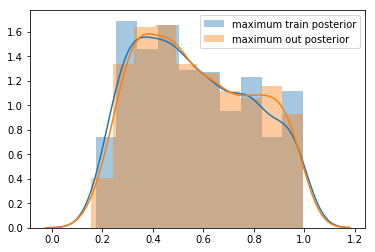

Accuracy of airplane : 65.10 %
Accuracy of automobile : 63.30 %
Accuracy of bird : 24.60 %
Accuracy of cat : 38.40 %
Accuracy of deer : 51.40 %
Accuracy of dog : 22.50 %
Accuracy of frog : 82.60 %
Accuracy of horse : 75.70 %
Accuracy of ship : 57.40 %
Accuracy of truck : 56.60 %

Total accuracy = 53.76 %


[640/2000] Inference accuracy = 51.80%, Classification accuracy = 53.76%


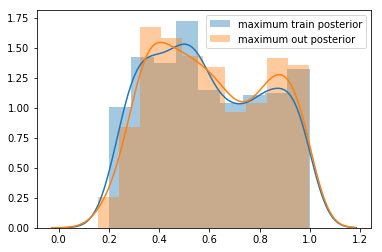

Accuracy of airplane : 65.50 %
Accuracy of automobile : 75.10 %
Accuracy of bird : 34.80 %
Accuracy of cat : 29.70 %
Accuracy of deer : 55.10 %
Accuracy of dog : 22.30 %
Accuracy of frog : 63.00 %
Accuracy of horse : 78.40 %
Accuracy of ship : 75.70 %
Accuracy of truck : 65.30 %

Total accuracy = 56.49 %


[660/2000] Inference accuracy = 51.25%, Classification accuracy = 56.49%


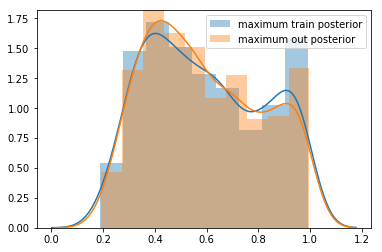

Accuracy of airplane : 64.00 %
Accuracy of automobile : 66.20 %
Accuracy of bird : 47.30 %
Accuracy of cat : 45.80 %
Accuracy of deer : 36.00 %
Accuracy of dog : 55.20 %
Accuracy of frog : 48.40 %
Accuracy of horse : 67.60 %
Accuracy of ship : 69.30 %
Accuracy of truck : 58.80 %

Total accuracy = 55.86 %


[680/2000] Inference accuracy = 51.64%, Classification accuracy = 55.86%


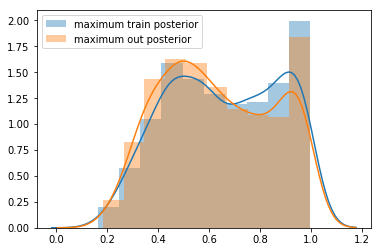

Accuracy of airplane : 69.20 %
Accuracy of automobile : 62.90 %
Accuracy of bird : 48.00 %
Accuracy of cat : 46.80 %
Accuracy of deer : 35.50 %
Accuracy of dog : 43.30 %
Accuracy of frog : 76.30 %
Accuracy of horse : 67.00 %
Accuracy of ship : 78.70 %
Accuracy of truck : 63.50 %

Total accuracy = 59.12 %


[700/2000] Inference accuracy = 50.94%, Classification accuracy = 59.12%


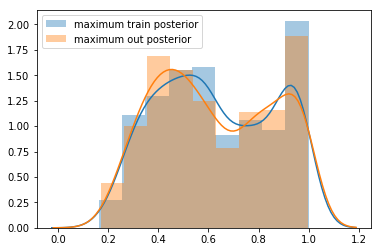

Accuracy of airplane : 75.30 %
Accuracy of automobile : 79.40 %
Accuracy of bird : 42.30 %
Accuracy of cat : 55.70 %
Accuracy of deer : 36.40 %
Accuracy of dog : 23.30 %
Accuracy of frog : 71.10 %
Accuracy of horse : 59.30 %
Accuracy of ship : 73.60 %
Accuracy of truck : 63.20 %

Total accuracy = 57.96 %


[720/2000] Inference accuracy = 48.75%, Classification accuracy = 57.96%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f93decfcb70>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

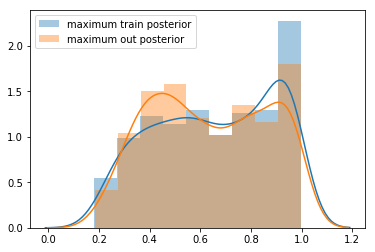

Accuracy of airplane : 75.50 %
Accuracy of automobile : 82.20 %
Accuracy of bird : 34.60 %
Accuracy of cat : 31.30 %
Accuracy of deer : 41.90 %
Accuracy of dog : 50.80 %
Accuracy of frog : 68.20 %
Accuracy of horse : 73.40 %
Accuracy of ship : 70.90 %
Accuracy of truck : 63.50 %

Total accuracy = 59.23 %


[740/2000] Inference accuracy = 52.50%, Classification accuracy = 59.23%


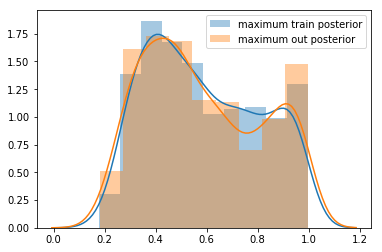

Accuracy of airplane : 54.90 %
Accuracy of automobile : 58.80 %
Accuracy of bird : 30.80 %
Accuracy of cat : 57.90 %
Accuracy of deer : 39.70 %
Accuracy of dog : 41.50 %
Accuracy of frog : 81.40 %
Accuracy of horse : 68.80 %
Accuracy of ship : 81.40 %
Accuracy of truck : 65.10 %

Total accuracy = 58.03 %


[760/2000] Inference accuracy = 50.39%, Classification accuracy = 58.03%


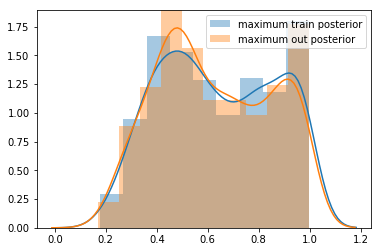

Accuracy of airplane : 56.70 %
Accuracy of automobile : 79.90 %
Accuracy of bird : 50.50 %
Accuracy of cat : 43.70 %
Accuracy of deer : 37.00 %
Accuracy of dog : 59.20 %
Accuracy of frog : 63.80 %
Accuracy of horse : 67.70 %
Accuracy of ship : 76.30 %
Accuracy of truck : 61.60 %

Total accuracy = 59.64 %


[780/2000] Inference accuracy = 51.56%, Classification accuracy = 59.64%


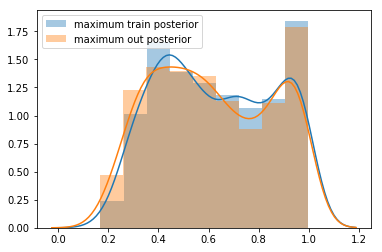

Accuracy of airplane : 62.50 %
Accuracy of automobile : 77.10 %
Accuracy of bird : 58.10 %
Accuracy of cat : 42.70 %
Accuracy of deer : 42.00 %
Accuracy of dog : 45.80 %
Accuracy of frog : 69.20 %
Accuracy of horse : 71.50 %
Accuracy of ship : 67.20 %
Accuracy of truck : 70.00 %

Total accuracy = 60.61 %


[800/2000] Inference accuracy = 49.22%, Classification accuracy = 60.61%


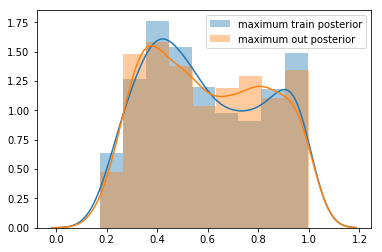

Accuracy of airplane : 58.10 %
Accuracy of automobile : 75.90 %
Accuracy of bird : 53.80 %
Accuracy of cat : 56.30 %
Accuracy of deer : 31.90 %
Accuracy of dog : 35.10 %
Accuracy of frog : 63.90 %
Accuracy of horse : 69.80 %
Accuracy of ship : 79.70 %
Accuracy of truck : 73.80 %

Total accuracy = 59.83 %


[820/2000] Inference accuracy = 52.42%, Classification accuracy = 59.83%


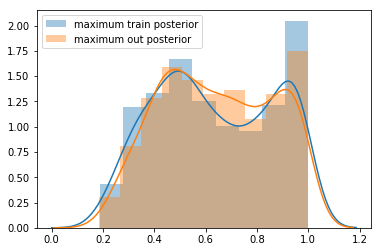

Accuracy of airplane : 71.80 %
Accuracy of automobile : 80.30 %
Accuracy of bird : 44.70 %
Accuracy of cat : 54.70 %
Accuracy of deer : 43.20 %
Accuracy of dog : 24.30 %
Accuracy of frog : 83.50 %
Accuracy of horse : 53.60 %
Accuracy of ship : 73.00 %
Accuracy of truck : 67.80 %

Total accuracy = 59.69 %


[840/2000] Inference accuracy = 50.94%, Classification accuracy = 59.69%


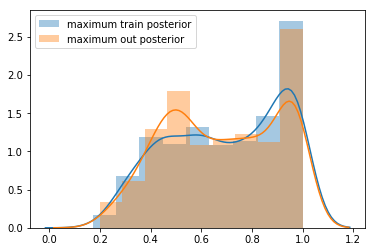

Accuracy of airplane : 69.40 %
Accuracy of automobile : 57.30 %
Accuracy of bird : 36.20 %
Accuracy of cat : 57.00 %
Accuracy of deer : 22.10 %
Accuracy of dog : 54.60 %
Accuracy of frog : 67.90 %
Accuracy of horse : 68.70 %
Accuracy of ship : 73.10 %
Accuracy of truck : 75.90 %

Total accuracy = 58.22 %


[860/2000] Inference accuracy = 53.20%, Classification accuracy = 58.22%


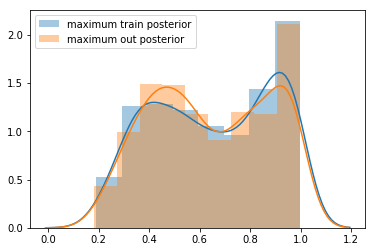

Accuracy of airplane : 61.90 %
Accuracy of automobile : 86.80 %
Accuracy of bird : 54.80 %
Accuracy of cat : 21.10 %
Accuracy of deer : 36.30 %
Accuracy of dog : 59.70 %
Accuracy of frog : 79.80 %
Accuracy of horse : 59.20 %
Accuracy of ship : 75.10 %
Accuracy of truck : 66.00 %

Total accuracy = 60.07 %


[880/2000] Inference accuracy = 52.42%, Classification accuracy = 60.07%


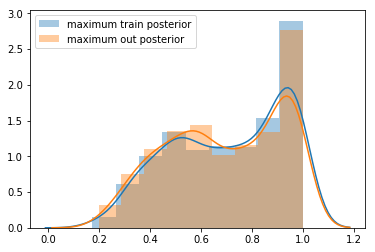

Accuracy of airplane : 79.10 %
Accuracy of automobile : 86.30 %
Accuracy of bird : 42.40 %
Accuracy of cat : 46.90 %
Accuracy of deer : 46.00 %
Accuracy of dog : 46.90 %
Accuracy of frog : 52.20 %
Accuracy of horse : 56.40 %
Accuracy of ship : 79.20 %
Accuracy of truck : 61.40 %

Total accuracy = 59.68 %


[900/2000] Inference accuracy = 51.80%, Classification accuracy = 59.68%


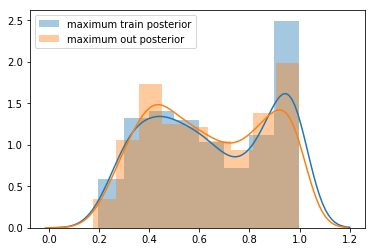

Accuracy of airplane : 78.90 %
Accuracy of automobile : 69.40 %
Accuracy of bird : 36.60 %
Accuracy of cat : 45.50 %
Accuracy of deer : 46.50 %
Accuracy of dog : 37.90 %
Accuracy of frog : 79.60 %
Accuracy of horse : 66.50 %
Accuracy of ship : 78.40 %
Accuracy of truck : 77.80 %

Total accuracy = 61.71 %


[920/2000] Inference accuracy = 51.95%, Classification accuracy = 61.71%


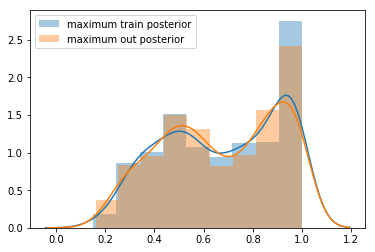

Accuracy of airplane : 62.90 %
Accuracy of automobile : 74.00 %
Accuracy of bird : 34.20 %
Accuracy of cat : 13.70 %
Accuracy of deer : 61.00 %
Accuracy of dog : 53.00 %
Accuracy of frog : 64.20 %
Accuracy of horse : 79.90 %
Accuracy of ship : 85.60 %
Accuracy of truck : 68.80 %

Total accuracy = 59.73 %


[940/2000] Inference accuracy = 52.34%, Classification accuracy = 59.73%


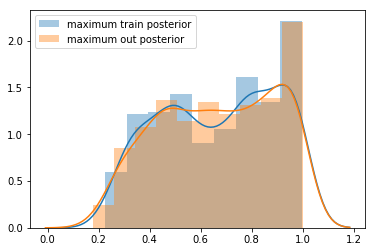

Accuracy of airplane : 77.70 %
Accuracy of automobile : 82.50 %
Accuracy of bird : 52.90 %
Accuracy of cat : 21.30 %
Accuracy of deer : 55.70 %
Accuracy of dog : 51.60 %
Accuracy of frog : 72.30 %
Accuracy of horse : 73.60 %
Accuracy of ship : 63.90 %
Accuracy of truck : 64.00 %

Total accuracy = 61.55 %


[960/2000] Inference accuracy = 50.08%, Classification accuracy = 61.55%


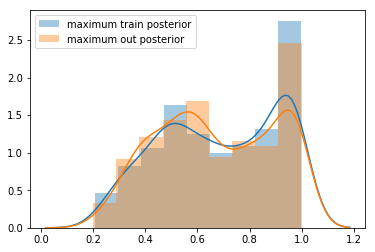

Accuracy of airplane : 75.00 %
Accuracy of automobile : 87.10 %
Accuracy of bird : 41.90 %
Accuracy of cat : 49.80 %
Accuracy of deer : 56.40 %
Accuracy of dog : 57.00 %
Accuracy of frog : 62.40 %
Accuracy of horse : 61.80 %
Accuracy of ship : 72.60 %
Accuracy of truck : 62.80 %

Total accuracy = 62.68 %


[980/2000] Inference accuracy = 53.28%, Classification accuracy = 62.68%


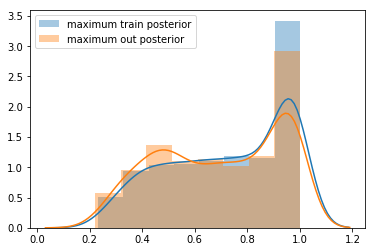

Accuracy of airplane : 73.20 %
Accuracy of automobile : 83.70 %
Accuracy of bird : 47.70 %
Accuracy of cat : 45.40 %
Accuracy of deer : 57.00 %
Accuracy of dog : 50.10 %
Accuracy of frog : 79.20 %
Accuracy of horse : 62.40 %
Accuracy of ship : 79.90 %
Accuracy of truck : 55.00 %

Total accuracy = 63.36 %


[1000/2000] Inference accuracy = 52.19%, Classification accuracy = 63.36%


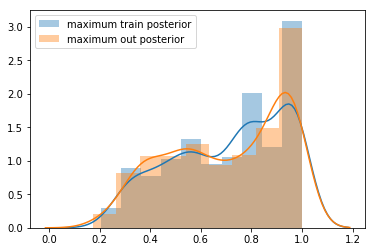

Accuracy of airplane : 65.90 %
Accuracy of automobile : 75.40 %
Accuracy of bird : 49.30 %
Accuracy of cat : 13.50 %
Accuracy of deer : 63.70 %
Accuracy of dog : 52.30 %
Accuracy of frog : 81.40 %
Accuracy of horse : 73.50 %
Accuracy of ship : 74.00 %
Accuracy of truck : 72.30 %

Total accuracy = 62.13 %


[1020/2000] Inference accuracy = 53.28%, Classification accuracy = 62.13%


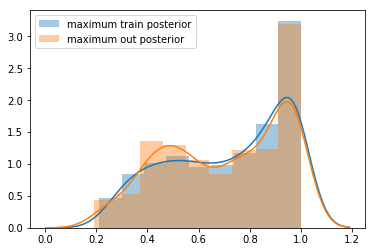

Accuracy of airplane : 63.30 %
Accuracy of automobile : 76.50 %
Accuracy of bird : 52.60 %
Accuracy of cat : 24.10 %
Accuracy of deer : 64.30 %
Accuracy of dog : 54.40 %
Accuracy of frog : 65.50 %
Accuracy of horse : 72.50 %
Accuracy of ship : 87.40 %
Accuracy of truck : 71.50 %

Total accuracy = 63.21 %


[1040/2000] Inference accuracy = 53.52%, Classification accuracy = 63.21%


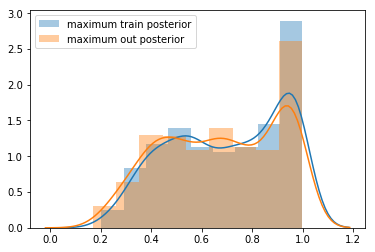

Accuracy of airplane : 72.50 %
Accuracy of automobile : 78.90 %
Accuracy of bird : 61.40 %
Accuracy of cat : 51.70 %
Accuracy of deer : 40.80 %
Accuracy of dog : 42.80 %
Accuracy of frog : 68.80 %
Accuracy of horse : 68.80 %
Accuracy of ship : 70.10 %
Accuracy of truck : 75.90 %

Total accuracy = 63.17 %


[1060/2000] Inference accuracy = 53.52%, Classification accuracy = 63.17%


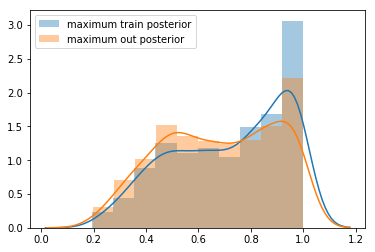

Accuracy of airplane : 54.50 %
Accuracy of automobile : 75.80 %
Accuracy of bird : 48.80 %
Accuracy of cat : 20.70 %
Accuracy of deer : 71.70 %
Accuracy of dog : 49.10 %
Accuracy of frog : 86.70 %
Accuracy of horse : 61.00 %
Accuracy of ship : 75.40 %
Accuracy of truck : 64.60 %

Total accuracy = 60.83 %


[1080/2000] Inference accuracy = 55.39%, Classification accuracy = 60.83%


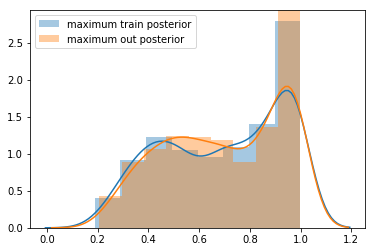

Accuracy of airplane : 78.90 %
Accuracy of automobile : 80.50 %
Accuracy of bird : 65.50 %
Accuracy of cat : 43.50 %
Accuracy of deer : 50.40 %
Accuracy of dog : 33.20 %
Accuracy of frog : 68.60 %
Accuracy of horse : 69.90 %
Accuracy of ship : 75.40 %
Accuracy of truck : 71.40 %

Total accuracy = 63.73 %


[1100/2000] Inference accuracy = 51.41%, Classification accuracy = 63.73%


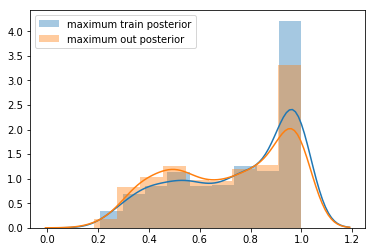

Accuracy of airplane : 58.50 %
Accuracy of automobile : 76.50 %
Accuracy of bird : 28.90 %
Accuracy of cat : 24.90 %
Accuracy of deer : 61.80 %
Accuracy of dog : 71.00 %
Accuracy of frog : 76.10 %
Accuracy of horse : 69.60 %
Accuracy of ship : 79.90 %
Accuracy of truck : 80.20 %

Total accuracy = 62.74 %


[1120/2000] Inference accuracy = 54.84%, Classification accuracy = 62.74%


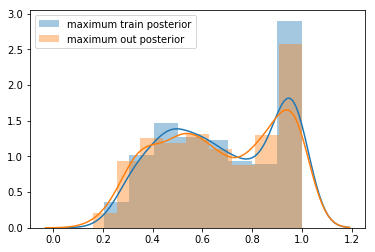

Accuracy of airplane : 70.50 %
Accuracy of automobile : 72.10 %
Accuracy of bird : 49.00 %
Accuracy of cat : 59.80 %
Accuracy of deer : 39.80 %
Accuracy of dog : 53.30 %
Accuracy of frog : 77.40 %
Accuracy of horse : 55.00 %
Accuracy of ship : 76.60 %
Accuracy of truck : 62.70 %

Total accuracy = 61.62 %


[1140/2000] Inference accuracy = 52.42%, Classification accuracy = 61.62%


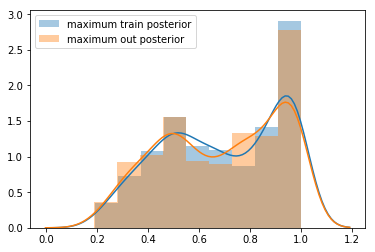

Accuracy of airplane : 67.50 %
Accuracy of automobile : 88.70 %
Accuracy of bird : 58.30 %
Accuracy of cat : 38.90 %
Accuracy of deer : 55.40 %
Accuracy of dog : 50.10 %
Accuracy of frog : 78.40 %
Accuracy of horse : 72.10 %
Accuracy of ship : 60.40 %
Accuracy of truck : 54.40 %

Total accuracy = 62.42 %


[1160/2000] Inference accuracy = 52.97%, Classification accuracy = 62.42%


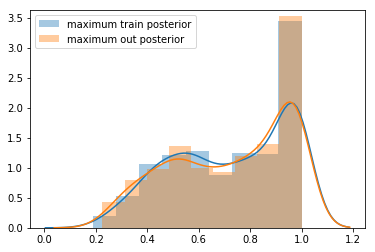

Accuracy of airplane : 71.80 %
Accuracy of automobile : 71.10 %
Accuracy of bird : 51.70 %
Accuracy of cat : 40.10 %
Accuracy of deer : 63.80 %
Accuracy of dog : 44.30 %
Accuracy of frog : 78.20 %
Accuracy of horse : 73.70 %
Accuracy of ship : 76.00 %
Accuracy of truck : 79.10 %

Total accuracy = 64.98 %


[1180/2000] Inference accuracy = 53.12%, Classification accuracy = 64.98%


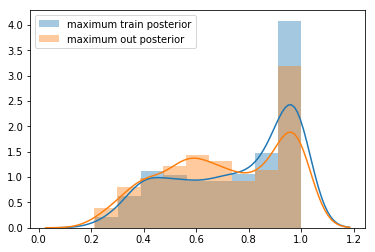

Accuracy of airplane : 71.20 %
Accuracy of automobile : 53.30 %
Accuracy of bird : 39.20 %
Accuracy of cat : 55.50 %
Accuracy of deer : 65.90 %
Accuracy of dog : 50.80 %
Accuracy of frog : 59.60 %
Accuracy of horse : 66.70 %
Accuracy of ship : 84.90 %
Accuracy of truck : 82.60 %

Total accuracy = 62.97 %


[1200/2000] Inference accuracy = 58.52%, Classification accuracy = 62.97%


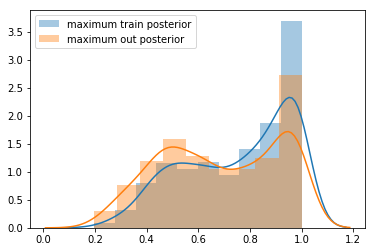

Accuracy of airplane : 71.40 %
Accuracy of automobile : 87.40 %
Accuracy of bird : 54.70 %
Accuracy of cat : 45.70 %
Accuracy of deer : 62.70 %
Accuracy of dog : 60.40 %
Accuracy of frog : 46.70 %
Accuracy of horse : 69.50 %
Accuracy of ship : 77.90 %
Accuracy of truck : 52.90 %

Total accuracy = 62.93 %


[1220/2000] Inference accuracy = 58.98%, Classification accuracy = 62.93%


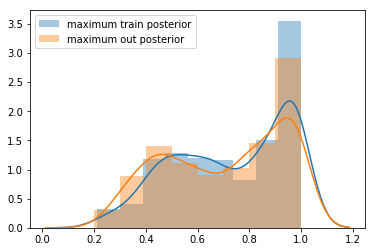

Accuracy of airplane : 72.50 %
Accuracy of automobile : 84.10 %
Accuracy of bird : 61.90 %
Accuracy of cat : 37.50 %
Accuracy of deer : 47.30 %
Accuracy of dog : 54.70 %
Accuracy of frog : 80.70 %
Accuracy of horse : 66.80 %
Accuracy of ship : 79.30 %
Accuracy of truck : 64.00 %

Total accuracy = 64.88 %


[1240/2000] Inference accuracy = 56.80%, Classification accuracy = 64.88%


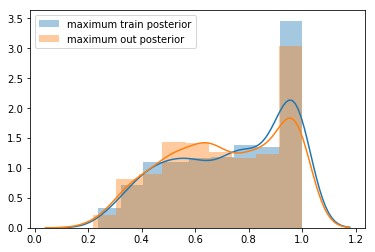

Accuracy of airplane : 67.20 %
Accuracy of automobile : 81.30 %
Accuracy of bird : 51.10 %
Accuracy of cat : 55.70 %
Accuracy of deer : 44.30 %
Accuracy of dog : 58.00 %
Accuracy of frog : 72.80 %
Accuracy of horse : 48.70 %
Accuracy of ship : 80.30 %
Accuracy of truck : 74.90 %

Total accuracy = 63.43 %


[1260/2000] Inference accuracy = 53.91%, Classification accuracy = 63.43%


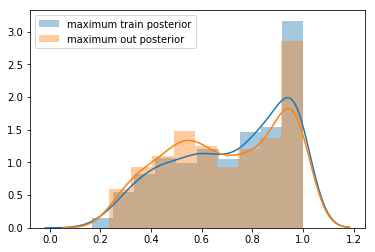

Accuracy of airplane : 74.00 %
Accuracy of automobile : 82.90 %
Accuracy of bird : 35.80 %
Accuracy of cat : 50.90 %
Accuracy of deer : 39.40 %
Accuracy of dog : 50.40 %
Accuracy of frog : 72.30 %
Accuracy of horse : 73.50 %
Accuracy of ship : 71.90 %
Accuracy of truck : 78.60 %

Total accuracy = 62.97 %


[1280/2000] Inference accuracy = 54.69%, Classification accuracy = 62.97%


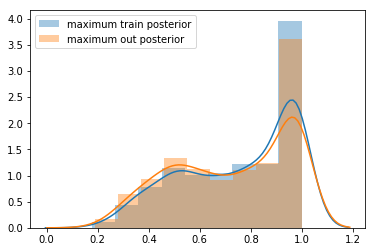

Accuracy of airplane : 62.40 %
Accuracy of automobile : 70.70 %
Accuracy of bird : 29.60 %
Accuracy of cat : 52.50 %
Accuracy of deer : 59.00 %
Accuracy of dog : 42.50 %
Accuracy of frog : 79.90 %
Accuracy of horse : 72.60 %
Accuracy of ship : 84.20 %
Accuracy of truck : 83.70 %

Total accuracy = 63.71 %


[1300/2000] Inference accuracy = 53.05%, Classification accuracy = 63.71%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f949006fa90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/local/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/local/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/local/lib/python3.6/multiprocessing/reducti

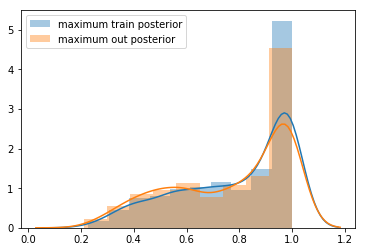

Accuracy of airplane : 69.90 %
Accuracy of automobile : 76.00 %
Accuracy of bird : 56.40 %
Accuracy of cat : 33.00 %
Accuracy of deer : 51.20 %
Accuracy of dog : 43.90 %
Accuracy of frog : 85.00 %
Accuracy of horse : 65.30 %
Accuracy of ship : 86.50 %
Accuracy of truck : 75.90 %

Total accuracy = 64.31 %


[1320/2000] Inference accuracy = 56.02%, Classification accuracy = 64.31%


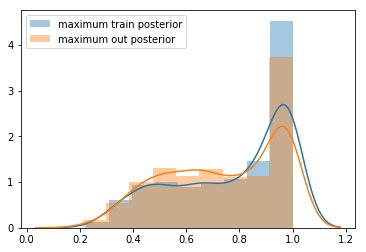

Accuracy of airplane : 71.50 %
Accuracy of automobile : 77.70 %
Accuracy of bird : 39.80 %
Accuracy of cat : 60.10 %
Accuracy of deer : 69.10 %
Accuracy of dog : 44.50 %
Accuracy of frog : 72.70 %
Accuracy of horse : 70.30 %
Accuracy of ship : 65.00 %
Accuracy of truck : 70.30 %

Total accuracy = 64.10 %


[1340/2000] Inference accuracy = 56.48%, Classification accuracy = 64.10%


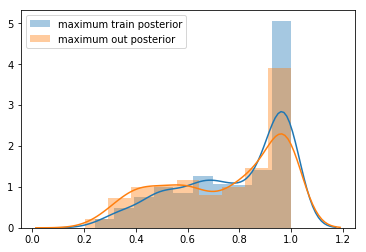

Accuracy of airplane : 67.50 %
Accuracy of automobile : 81.30 %
Accuracy of bird : 65.00 %
Accuracy of cat : 33.50 %
Accuracy of deer : 63.70 %
Accuracy of dog : 49.50 %
Accuracy of frog : 67.70 %
Accuracy of horse : 74.60 %
Accuracy of ship : 81.60 %
Accuracy of truck : 65.30 %

Total accuracy = 64.97 %


[1360/2000] Inference accuracy = 56.64%, Classification accuracy = 64.97%


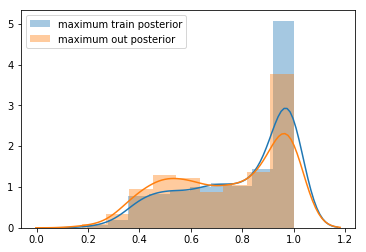

Accuracy of airplane : 39.00 %
Accuracy of automobile : 80.30 %
Accuracy of bird : 47.00 %
Accuracy of cat : 52.20 %
Accuracy of deer : 69.50 %
Accuracy of dog : 52.00 %
Accuracy of frog : 79.50 %
Accuracy of horse : 65.90 %
Accuracy of ship : 80.30 %
Accuracy of truck : 67.60 %

Total accuracy = 63.33 %


[1380/2000] Inference accuracy = 56.80%, Classification accuracy = 63.33%


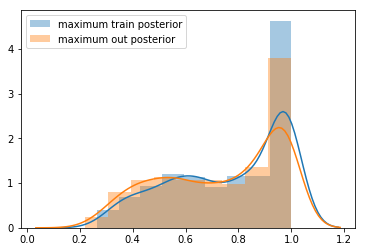

Accuracy of airplane : 80.50 %
Accuracy of automobile : 65.70 %
Accuracy of bird : 45.30 %
Accuracy of cat : 47.00 %
Accuracy of deer : 63.00 %
Accuracy of dog : 55.30 %
Accuracy of frog : 74.00 %
Accuracy of horse : 79.80 %
Accuracy of ship : 66.50 %
Accuracy of truck : 75.60 %

Total accuracy = 65.27 %


[1400/2000] Inference accuracy = 58.59%, Classification accuracy = 65.27%


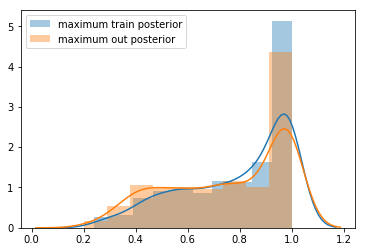

Accuracy of airplane : 50.30 %
Accuracy of automobile : 85.10 %
Accuracy of bird : 57.50 %
Accuracy of cat : 64.90 %
Accuracy of deer : 44.00 %
Accuracy of dog : 35.30 %
Accuracy of frog : 70.50 %
Accuracy of horse : 76.40 %
Accuracy of ship : 84.20 %
Accuracy of truck : 65.50 %

Total accuracy = 63.37 %


[1420/2000] Inference accuracy = 57.27%, Classification accuracy = 63.37%


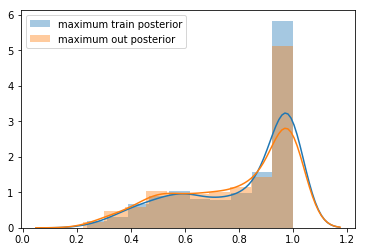

Accuracy of airplane : 77.70 %
Accuracy of automobile : 82.80 %
Accuracy of bird : 31.50 %
Accuracy of cat : 47.10 %
Accuracy of deer : 52.00 %
Accuracy of dog : 62.30 %
Accuracy of frog : 70.80 %
Accuracy of horse : 78.10 %
Accuracy of ship : 80.50 %
Accuracy of truck : 73.00 %

Total accuracy = 65.58 %


[1440/2000] Inference accuracy = 56.80%, Classification accuracy = 65.58%


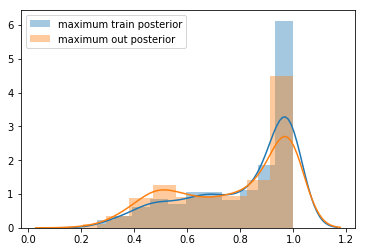

Accuracy of airplane : 80.20 %
Accuracy of automobile : 75.80 %
Accuracy of bird : 57.70 %
Accuracy of cat : 51.40 %
Accuracy of deer : 54.90 %
Accuracy of dog : 43.80 %
Accuracy of frog : 78.90 %
Accuracy of horse : 63.30 %
Accuracy of ship : 78.90 %
Accuracy of truck : 77.90 %

Total accuracy = 66.28 %


[1460/2000] Inference accuracy = 59.53%, Classification accuracy = 66.28%


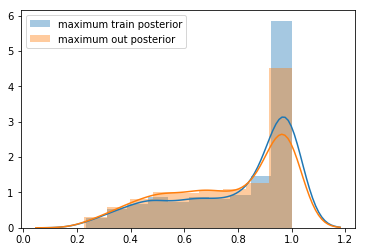

Accuracy of airplane : 79.70 %
Accuracy of automobile : 74.30 %
Accuracy of bird : 58.50 %
Accuracy of cat : 41.40 %
Accuracy of deer : 54.10 %
Accuracy of dog : 21.60 %
Accuracy of frog : 83.20 %
Accuracy of horse : 74.60 %
Accuracy of ship : 78.30 %
Accuracy of truck : 85.00 %

Total accuracy = 65.07 %


[1480/2000] Inference accuracy = 57.34%, Classification accuracy = 65.07%


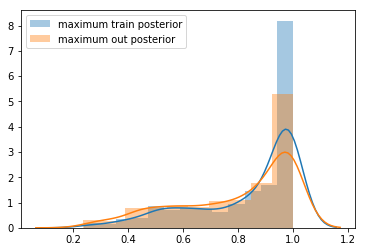

Accuracy of airplane : 80.60 %
Accuracy of automobile : 82.50 %
Accuracy of bird : 48.90 %
Accuracy of cat : 52.30 %
Accuracy of deer : 52.70 %
Accuracy of dog : 51.60 %
Accuracy of frog : 67.10 %
Accuracy of horse : 75.60 %
Accuracy of ship : 77.20 %
Accuracy of truck : 75.80 %

Total accuracy = 66.43 %


[1500/2000] Inference accuracy = 56.64%, Classification accuracy = 66.43%


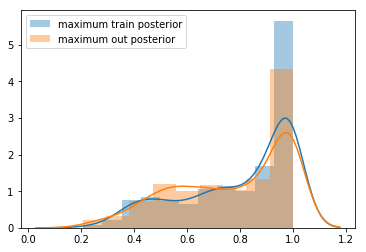

Accuracy of airplane : 78.90 %
Accuracy of automobile : 60.90 %
Accuracy of bird : 58.90 %
Accuracy of cat : 42.60 %
Accuracy of deer : 56.80 %
Accuracy of dog : 62.50 %
Accuracy of frog : 73.40 %
Accuracy of horse : 61.60 %
Accuracy of ship : 86.90 %
Accuracy of truck : 74.90 %

Total accuracy = 65.74 %


[1520/2000] Inference accuracy = 57.27%, Classification accuracy = 65.74%


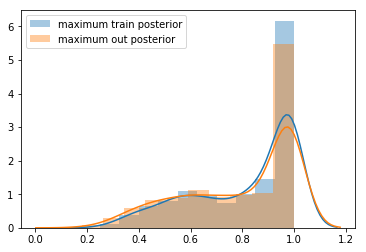

Accuracy of airplane : 74.40 %
Accuracy of automobile : 83.30 %
Accuracy of bird : 53.20 %
Accuracy of cat : 49.30 %
Accuracy of deer : 60.00 %
Accuracy of dog : 53.60 %
Accuracy of frog : 58.70 %
Accuracy of horse : 77.50 %
Accuracy of ship : 84.90 %
Accuracy of truck : 70.60 %

Total accuracy = 66.55 %


[1540/2000] Inference accuracy = 57.03%, Classification accuracy = 66.55%


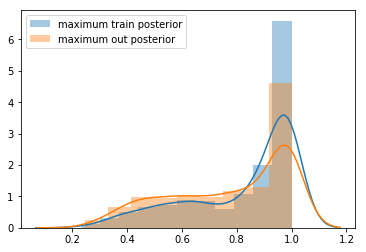

Accuracy of airplane : 68.40 %
Accuracy of automobile : 82.80 %
Accuracy of bird : 55.60 %
Accuracy of cat : 56.80 %
Accuracy of deer : 61.30 %
Accuracy of dog : 42.80 %
Accuracy of frog : 76.50 %
Accuracy of horse : 71.80 %
Accuracy of ship : 82.20 %
Accuracy of truck : 72.70 %

Total accuracy = 67.09 %


[1560/2000] Inference accuracy = 58.36%, Classification accuracy = 67.09%


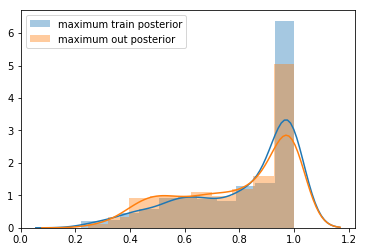

Accuracy of airplane : 75.30 %
Accuracy of automobile : 77.90 %
Accuracy of bird : 52.50 %
Accuracy of cat : 47.70 %
Accuracy of deer : 57.90 %
Accuracy of dog : 67.00 %
Accuracy of frog : 70.80 %
Accuracy of horse : 65.70 %
Accuracy of ship : 70.30 %
Accuracy of truck : 79.90 %

Total accuracy = 66.50 %


[1580/2000] Inference accuracy = 57.97%, Classification accuracy = 66.50%


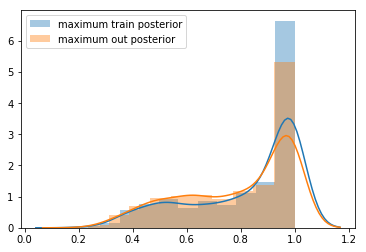

Accuracy of airplane : 67.30 %
Accuracy of automobile : 75.90 %
Accuracy of bird : 52.70 %
Accuracy of cat : 45.30 %
Accuracy of deer : 63.20 %
Accuracy of dog : 61.20 %
Accuracy of frog : 70.60 %
Accuracy of horse : 74.40 %
Accuracy of ship : 79.00 %
Accuracy of truck : 78.60 %

Total accuracy = 66.82 %


[1600/2000] Inference accuracy = 56.95%, Classification accuracy = 66.82%


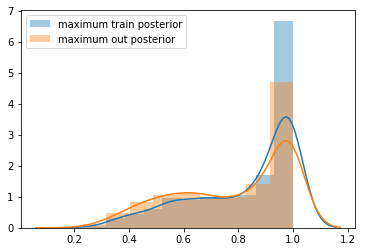

Accuracy of airplane : 77.80 %
Accuracy of automobile : 74.80 %
Accuracy of bird : 54.50 %
Accuracy of cat : 56.50 %
Accuracy of deer : 51.60 %
Accuracy of dog : 58.00 %
Accuracy of frog : 62.70 %
Accuracy of horse : 75.70 %
Accuracy of ship : 79.20 %
Accuracy of truck : 70.70 %

Total accuracy = 66.15 %


[1620/2000] Inference accuracy = 59.53%, Classification accuracy = 66.15%


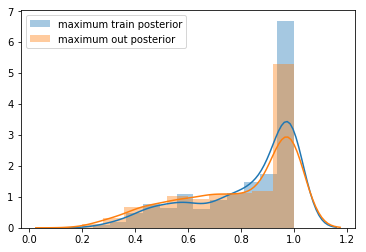

Accuracy of airplane : 77.50 %
Accuracy of automobile : 72.00 %
Accuracy of bird : 59.50 %
Accuracy of cat : 51.70 %
Accuracy of deer : 53.90 %
Accuracy of dog : 52.50 %
Accuracy of frog : 77.20 %
Accuracy of horse : 70.50 %
Accuracy of ship : 77.60 %
Accuracy of truck : 78.00 %

Total accuracy = 67.04 %


[1640/2000] Inference accuracy = 57.73%, Classification accuracy = 67.04%


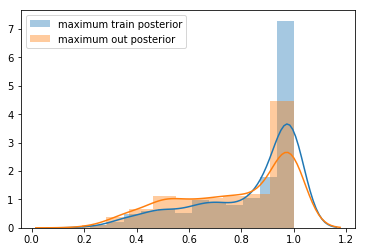

Accuracy of airplane : 76.20 %
Accuracy of automobile : 82.90 %
Accuracy of bird : 66.20 %
Accuracy of cat : 51.10 %
Accuracy of deer : 46.00 %
Accuracy of dog : 57.30 %
Accuracy of frog : 76.30 %
Accuracy of horse : 68.40 %
Accuracy of ship : 82.70 %
Accuracy of truck : 68.80 %

Total accuracy = 67.59 %


[1660/2000] Inference accuracy = 59.53%, Classification accuracy = 67.59%


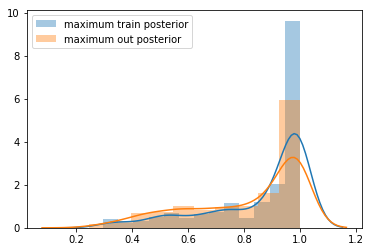

Accuracy of airplane : 75.10 %
Accuracy of automobile : 82.70 %
Accuracy of bird : 48.10 %
Accuracy of cat : 52.70 %
Accuracy of deer : 45.70 %
Accuracy of dog : 57.90 %
Accuracy of frog : 80.20 %
Accuracy of horse : 65.50 %
Accuracy of ship : 82.30 %
Accuracy of truck : 65.70 %

Total accuracy = 65.59 %


[1680/2000] Inference accuracy = 61.02%, Classification accuracy = 65.59%


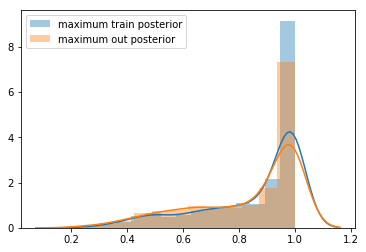

Accuracy of airplane : 73.60 %
Accuracy of automobile : 76.60 %
Accuracy of bird : 58.40 %
Accuracy of cat : 34.10 %
Accuracy of deer : 59.40 %
Accuracy of dog : 70.30 %
Accuracy of frog : 74.30 %
Accuracy of horse : 75.00 %
Accuracy of ship : 74.90 %
Accuracy of truck : 75.10 %

Total accuracy = 67.17 %


[1700/2000] Inference accuracy = 57.03%, Classification accuracy = 67.17%


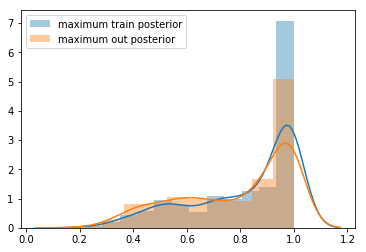

Accuracy of airplane : 74.20 %
Accuracy of automobile : 75.30 %
Accuracy of bird : 65.10 %
Accuracy of cat : 51.20 %
Accuracy of deer : 57.30 %
Accuracy of dog : 40.80 %
Accuracy of frog : 68.90 %
Accuracy of horse : 80.60 %
Accuracy of ship : 64.80 %
Accuracy of truck : 80.60 %

Total accuracy = 65.88 %


[1720/2000] Inference accuracy = 57.81%, Classification accuracy = 65.88%


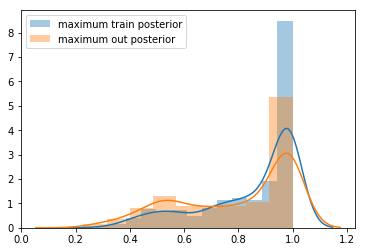

Accuracy of airplane : 69.90 %
Accuracy of automobile : 81.90 %
Accuracy of bird : 69.40 %
Accuracy of cat : 33.60 %
Accuracy of deer : 58.80 %
Accuracy of dog : 64.40 %
Accuracy of frog : 76.60 %
Accuracy of horse : 62.80 %
Accuracy of ship : 80.30 %
Accuracy of truck : 75.20 %

Total accuracy = 67.29 %


[1740/2000] Inference accuracy = 60.00%, Classification accuracy = 67.29%


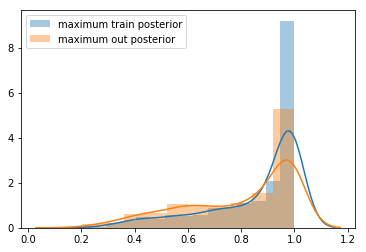

Accuracy of airplane : 78.40 %
Accuracy of automobile : 80.50 %
Accuracy of bird : 59.30 %
Accuracy of cat : 46.80 %
Accuracy of deer : 51.60 %
Accuracy of dog : 58.20 %
Accuracy of frog : 82.50 %
Accuracy of horse : 67.90 %
Accuracy of ship : 73.80 %
Accuracy of truck : 75.50 %

Total accuracy = 67.45 %


[1760/2000] Inference accuracy = 62.81%, Classification accuracy = 67.45%


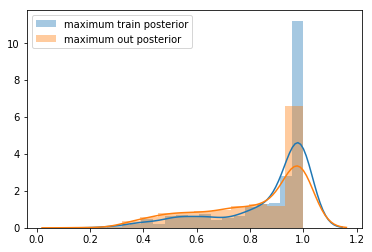

Accuracy of airplane : 73.60 %
Accuracy of automobile : 78.10 %
Accuracy of bird : 49.50 %
Accuracy of cat : 54.20 %
Accuracy of deer : 57.90 %
Accuracy of dog : 57.60 %
Accuracy of frog : 76.80 %
Accuracy of horse : 71.40 %
Accuracy of ship : 82.40 %
Accuracy of truck : 81.30 %

Total accuracy = 68.28 %


[1780/2000] Inference accuracy = 62.34%, Classification accuracy = 68.28%


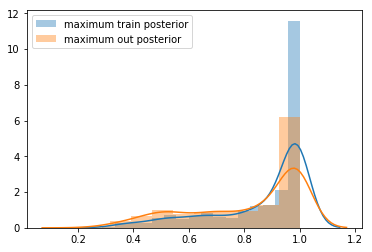

Accuracy of airplane : 77.10 %
Accuracy of automobile : 84.60 %
Accuracy of bird : 55.30 %
Accuracy of cat : 51.70 %
Accuracy of deer : 58.50 %
Accuracy of dog : 55.80 %
Accuracy of frog : 70.60 %
Accuracy of horse : 66.00 %
Accuracy of ship : 78.20 %
Accuracy of truck : 73.10 %

Total accuracy = 67.09 %


[1800/2000] Inference accuracy = 60.23%, Classification accuracy = 67.09%


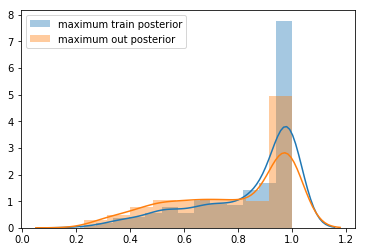

Accuracy of airplane : 71.90 %
Accuracy of automobile : 81.60 %
Accuracy of bird : 57.60 %
Accuracy of cat : 39.60 %
Accuracy of deer : 66.20 %
Accuracy of dog : 53.80 %
Accuracy of frog : 76.70 %
Accuracy of horse : 69.30 %
Accuracy of ship : 80.60 %
Accuracy of truck : 73.70 %

Total accuracy = 67.10 %


[1820/2000] Inference accuracy = 59.14%, Classification accuracy = 67.10%


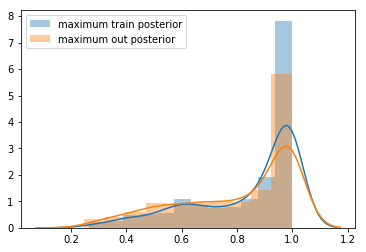

Accuracy of airplane : 76.00 %
Accuracy of automobile : 71.50 %
Accuracy of bird : 55.40 %
Accuracy of cat : 60.20 %
Accuracy of deer : 46.50 %
Accuracy of dog : 51.60 %
Accuracy of frog : 66.30 %
Accuracy of horse : 67.00 %
Accuracy of ship : 81.20 %
Accuracy of truck : 70.70 %

Total accuracy = 64.64 %


[1840/2000] Inference accuracy = 58.91%, Classification accuracy = 64.64%


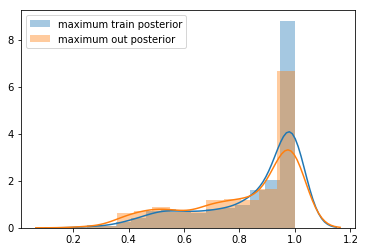

Accuracy of airplane : 71.90 %
Accuracy of automobile : 77.90 %
Accuracy of bird : 50.60 %
Accuracy of cat : 48.70 %
Accuracy of deer : 59.30 %
Accuracy of dog : 38.90 %
Accuracy of frog : 84.20 %
Accuracy of horse : 80.30 %
Accuracy of ship : 78.00 %
Accuracy of truck : 73.30 %

Total accuracy = 66.31 %


[1860/2000] Inference accuracy = 58.91%, Classification accuracy = 66.31%


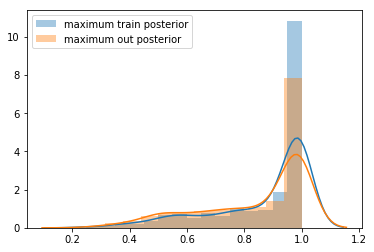

Accuracy of airplane : 78.80 %
Accuracy of automobile : 86.30 %
Accuracy of bird : 63.20 %
Accuracy of cat : 50.40 %
Accuracy of deer : 57.60 %
Accuracy of dog : 52.60 %
Accuracy of frog : 73.00 %
Accuracy of horse : 67.30 %
Accuracy of ship : 78.80 %
Accuracy of truck : 72.20 %

Total accuracy = 68.02 %


[1880/2000] Inference accuracy = 59.53%, Classification accuracy = 68.02%


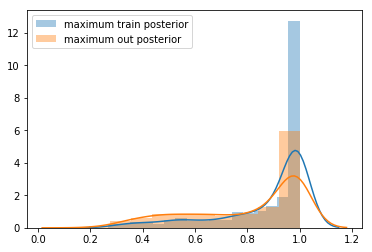

Accuracy of airplane : 74.70 %
Accuracy of automobile : 75.70 %
Accuracy of bird : 31.90 %
Accuracy of cat : 30.20 %
Accuracy of deer : 70.00 %
Accuracy of dog : 70.50 %
Accuracy of frog : 57.00 %
Accuracy of horse : 80.00 %
Accuracy of ship : 82.10 %
Accuracy of truck : 83.20 %

Total accuracy = 65.53 %


[1900/2000] Inference accuracy = 62.34%, Classification accuracy = 65.53%


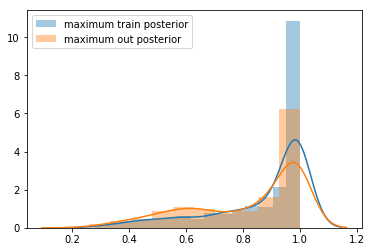

Accuracy of airplane : 77.30 %
Accuracy of automobile : 81.80 %
Accuracy of bird : 44.30 %
Accuracy of cat : 44.50 %
Accuracy of deer : 64.40 %
Accuracy of dog : 51.70 %
Accuracy of frog : 83.20 %
Accuracy of horse : 79.10 %
Accuracy of ship : 76.50 %
Accuracy of truck : 73.70 %

Total accuracy = 67.65 %


[1920/2000] Inference accuracy = 61.41%, Classification accuracy = 67.65%


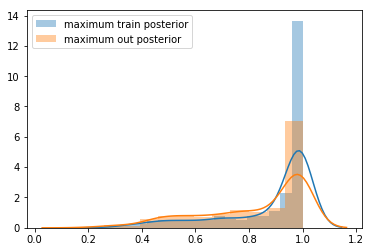

Accuracy of airplane : 72.00 %
Accuracy of automobile : 86.70 %
Accuracy of bird : 58.20 %
Accuracy of cat : 43.80 %
Accuracy of deer : 57.60 %
Accuracy of dog : 58.80 %
Accuracy of frog : 82.20 %
Accuracy of horse : 70.30 %
Accuracy of ship : 76.20 %
Accuracy of truck : 77.30 %

Total accuracy = 68.31 %


[1940/2000] Inference accuracy = 60.70%, Classification accuracy = 68.31%


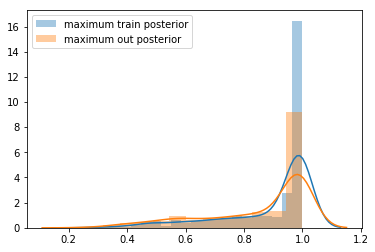

Accuracy of airplane : 81.90 %
Accuracy of automobile : 83.90 %
Accuracy of bird : 57.10 %
Accuracy of cat : 27.00 %
Accuracy of deer : 65.00 %
Accuracy of dog : 63.40 %
Accuracy of frog : 85.20 %
Accuracy of horse : 73.70 %
Accuracy of ship : 62.80 %
Accuracy of truck : 75.50 %

Total accuracy = 67.55 %


[1960/2000] Inference accuracy = 60.00%, Classification accuracy = 67.55%


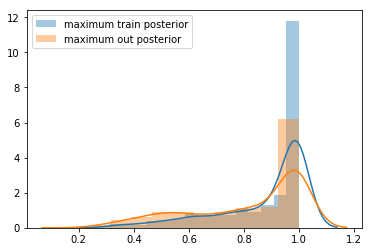

Accuracy of airplane : 66.10 %
Accuracy of automobile : 75.10 %
Accuracy of bird : 57.60 %
Accuracy of cat : 56.30 %
Accuracy of deer : 46.90 %
Accuracy of dog : 54.60 %
Accuracy of frog : 80.90 %
Accuracy of horse : 69.20 %
Accuracy of ship : 80.90 %
Accuracy of truck : 82.30 %

Total accuracy = 66.99 %


[1980/2000] Inference accuracy = 63.12%, Classification accuracy = 66.99%


In [8]:
adversarial_train(infer_net, net, trainloader, outloader, testloader,
                      infer_optim, infer_loss, class_optim, class_loss, n_epochs, 5, 1)